<a href="https://colab.research.google.com/github/Archi2903/AI-in-Engenery/blob/main/Project_LSTM_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Denoising TEM Data with LSTM Autoencoder

In [1]:
# Synthetic TEM Data Generation

import numpy as np

# Example: generate one synthetic clean TEM decay signal (normalized)
def generate_clean_signal(n_points=50):
    t = np.logspace(-5, -2, n_points)  # time (s)
    y = np.zeros_like(t)
    # Sum of a few decaying exponentials
    for A, tau in zip(np.random.uniform(0.5,1.5,3), np.random.uniform(0.01,0.1,3)):
        y += A * np.exp(-t/tau)
    y = y / np.max(y)  # normalize amplitude
    return t, y

# Generate dataset
n_samples = 200
times = []
clean_signals = []
for i in range(n_samples):
    t, y = generate_clean_signal()
    times.append(t)
    clean_signals.append(y)


In [2]:
# Noise

def add_noise(y, t):
    y = np.array(y)
    sigma_const = 0.01*np.max(y)
    noisy_const = y + np.random.normal(0, sigma_const, size=y.shape)

    sigma_base = 0.1*np.max(y)
    sigma_var = sigma_base * (1 + t/t[-1])
    noisy_var = y + np.random.normal(0, sigma_var)

    noisy_imp = y.copy()
    for j in range(len(y)):
        if np.random.rand() < 0.05:
            noisy_imp[j] += np.random.normal(0, 3*np.std(y))

    noisy_sin = y + 0.05 * np.sin(2*np.pi*50 * t)  # 50 Hz sine

    return noisy_const, noisy_var, noisy_imp, noisy_sin

X_noisy = []
Y_clean = []
for y in clean_signals:
    # times array is same for all or could vary, here assume same length
    noisy_list = add_noise(y, t)
    for noisy in noisy_list:
        X_noisy.append(noisy.reshape(-1,1))
        Y_clean.append(y.reshape(-1,1))
X_noisy = np.array(X_noisy)
Y_clean = np.array(Y_clean)
print("Dataset shape:", X_noisy.shape, Y_clean.shape)


Dataset shape: (800, 50, 1) (800, 50, 1)


In [3]:
# Train dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

timesteps = X_noisy.shape[1]  # e.g. 50
features = 1

model = Sequential([
    LSTM(128, input_shape=(timesteps, features)),  # encoder
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),             # decoder
    TimeDistributed(Dense(1))
])
model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Model traning

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_noisy, Y_clean, test_size=0.2, random_state=42)
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=300, batch_size=32, verbose=2
)


Epoch 1/300
20/20 - 6s - 316ms/step - loss: 0.1807 - val_loss: 0.0490
Epoch 2/300
20/20 - 2s - 102ms/step - loss: 0.0290 - val_loss: 0.0190
Epoch 3/300
20/20 - 0s - 14ms/step - loss: 0.0159 - val_loss: 0.0128
Epoch 4/300
20/20 - 0s - 13ms/step - loss: 0.0109 - val_loss: 0.0093
Epoch 5/300
20/20 - 0s - 13ms/step - loss: 0.0074 - val_loss: 0.0060
Epoch 6/300
20/20 - 0s - 13ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 7/300
20/20 - 0s - 13ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 8/300
20/20 - 0s - 13ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 9/300
20/20 - 0s - 13ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 10/300
20/20 - 0s - 13ms/step - loss: 0.0028 - val_loss: 0.0197
Epoch 11/300
20/20 - 0s - 13ms/step - loss: 0.0065 - val_loss: 0.0048
Epoch 12/300
20/20 - 0s - 14ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 13/300
20/20 - 0s - 13ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 14/300
20/20 - 0s - 13ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 15/300
20/20 - 0s - 1

In [5]:
# Performance and evaluate

import numpy as np

def compute_snr(clean, signal):
    # Avoid zero-division
    noise = clean - signal
    # Add a small epsilon to the denominator to avoid division by zero if noise variance is 0
    return 10*np.log10(np.var(clean) / (np.var(noise) + 1e-8))

# Select a sample from the validation set for demonstration
sample_index = 0
y_noisy = X_val[sample_index]
y_clean = Y_val[sample_index]
y_denoised = model.predict(y_noisy.reshape(1, -1, 1))[0]


snr_noisy = compute_snr(y_clean, y_noisy)
snr_denoised = compute_snr(y_clean, y_denoised)

print(f"SNR of noisy signal: {snr_noisy:.2f} dB")
print(f"SNR of denoised signal: {snr_denoised:.2f} dB")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
SNR of noisy signal: 12.78 dB
SNR of denoised signal: 28.91 dB


In [6]:
def compute_rmspe(y_true, y_pred):
    # Exclude points where true value is zero
    mask = y_true != 0
    return np.sqrt(np.mean(((y_pred[mask] - y_true[mask]) / y_true[mask])**2))

rmspe = compute_rmspe(y_clean, y_denoised)


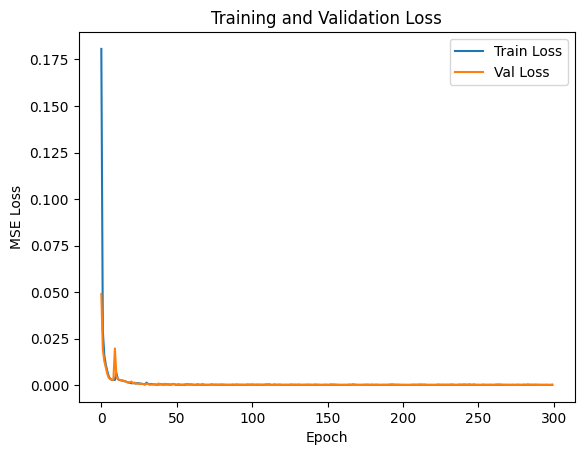

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


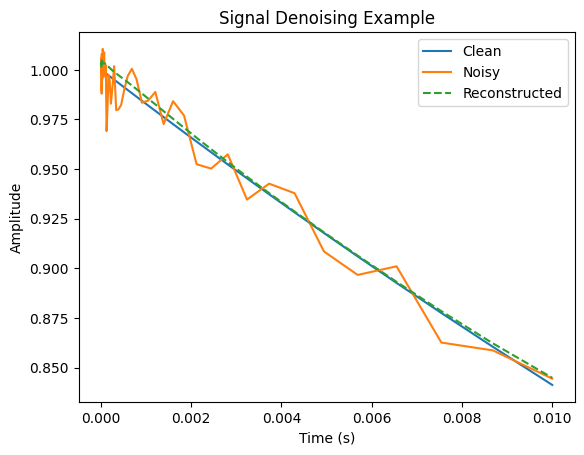

In [7]:
import matplotlib.pyplot as plt

# Example: plot loss curves
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Example: compare signals
example_idx = 0
y_clean = Y_val[example_idx,:,0]
y_noisy = X_val[example_idx,:,0]
y_denoised = model.predict(y_noisy.reshape(1,-1,1))[0,:,0]

plt.figure()
plt.plot(t, y_clean, label='Clean')
plt.plot(t, y_noisy, label='Noisy')
plt.plot(t, y_denoised, '--', label='Reconstructed')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.legend(); plt.title('Signal Denoising Example')
plt.show()
